Muyuan He Tutorial of how a neural network performs a NLP

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.14.0
GPU is available


Download the dataset. I'm trying on the Reddit dataset. Because I have lots of karma on reddit, lol. (somehow reddit didn't work. I'm actually using IMDB reviews)


In [3]:
import gc
gc.collect()
# First I tried to load the entire reddit dataset, but it's too large and crashed
# the RAM.
# Load a subset of the data
num_samples = 1 # Here I'm only using 1 of the dataset.
# main job
# train_data, test_data = tfds.load(name="reddit", split=["train", "test"],
#                                   batch_size=-1, as_supervised=True).take(num_samples)
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)
train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFLPL0S/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFLPL0S/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFLPL0S/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Somehow the reddit dataset seems too large. I will just use the smaller imdb review dataset then.
Let's see what the dataset look like: A review with a number either positive or negative, representing if the review is good or bad.
The model will finally give a score either positive or negative based only on the text.



In [4]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [5]:
train_examples[:2]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [6]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [7]:
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
# Here I chooose this model from TF hub because it has 128 dimensions.
# Because what we are reading is human language for movie, I think it can be pretty complicated
# therefore it might need more semantic relationship, so I choose something with more dimensions.
# I'm also using this one because it has a lower compression.
# Although this model will be more computionally costly to execute, I'm curious to see
# if this improvement is marginal.
# The normalization model use is because it removes punctuation. Make it simplier
# and potentially more accurate.
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 1.15015066e+00,  7.80130103e-02,  9.26615447e-02,
         2.83361435e-01,  9.67164431e-03, -1.49186060e-01,
         3.35665733e-01, -3.50244790e-01, -8.28830618e-03,
        -1.87714081e-02, -3.33069824e-02, -6.33094192e-01,
        -3.75421256e-01, -2.77732849e-01, -9.66175571e-02,
         1.72553629e-01, -1.33676574e-01,  3.80765870e-02,
        -2.75138199e-01,  4.94762301e-01,  3.93051840e-02,
         1.34496227e-01, -2.70728230e-01,  1.78942848e-02,
        -2.41071522e-01,  2.71089785e-02,  1.02333419e-01,
        -1.06628530e-01,  5.24298586e-02,  1.19170472e-01,
        -6.67077256e-03,  3.39231521e-01,  1.13014966e-01,
         1.06842585e-01,  3.91571134e-01, -1.89536288e-01,
        -1.74000353e-01, -1.06444150e-01, -1.34200439e-01,
         1.73583925e-01, -2.77695060e-01, -4.33591381e-02,
        -3.91500629e-02, -1.98340893e-01,  2.74854712e-02,
         2.76702970e-01,  1.40702844e-01, -3.14256102e-01,
      

In [8]:
model = tf.keras.Sequential() # initialize linear stack of layers
model.add(hub_layer) # convert text into vector
model.add(tf.keras.layers.Dense(32, activation='gelu')) # Here I use gelu which is
# Gaussian error linear unit. I use gelu because it's faster due to the simplicity.
# gelu is also very good for GPT
# 32 neurons is because that makes the model a little bit more complicated. I think human language is
# very complicated.
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


Model description:
Input layer: The model takes raw text as input.
Text imbedding layer: transfer learning. I use pre-trained model from tensor flow. Take text into vectors.

---

Each word is represented by 128 dimensions normalized. Trainable is true so we can reweight the model.

---

For Dense layer: I used 32 neurons for Gaussian Error Linear Unit. Since 32 neurons, we have 32 outputs from dense layer

---

For Output layer: provide a raw score for each review, either positive or negative.

Make the loss function:
loss function of choice here is tf.losses.BinaryCrossentropy, this choice is because it works perfectly for binary choices, which measures the difference between prediction and actual label.
logits is true to make sure output of model is raw info instead of percentage.

In [9]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
# I'm using adam optimizer because it's popular and it adjusts the learning rate based on
# historical gradients. Making it faster.

Make validation set

In [10]:
x_val = train_examples[:4000]
partial_x_train = train_examples[4000:]

y_val = train_labels[:4000]
partial_y_train = train_labels[4000:]

Training the model:

In [11]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# epoch is set to 15, means the model will see the dataset 15 times.
# batch size is 512 because it will divide the data for less memory usage

Epoch 1/15
42/42 [==============================] - 18s 278ms/step - loss: 0.5394 - accuracy: 0.7647 - val_loss: 0.3717 - val_accuracy: 0.8595
Epoch 2/15
42/42 [==============================] - 12s 277ms/step - loss: 0.2654 - accuracy: 0.8991 - val_loss: 0.2776 - val_accuracy: 0.8855
Epoch 3/15
42/42 [==============================] - 11s 273ms/step - loss: 0.1583 - accuracy: 0.9456 - val_loss: 0.2529 - val_accuracy: 0.9025
Epoch 4/15
42/42 [==============================] - 11s 269ms/step - loss: 0.0962 - accuracy: 0.9732 - val_loss: 0.2602 - val_accuracy: 0.8967
Epoch 5/15
42/42 [==============================] - 10s 231ms/step - loss: 0.0582 - accuracy: 0.9879 - val_loss: 0.2679 - val_accuracy: 0.9000
Epoch 6/15
42/42 [==============================] - 9s 209ms/step - loss: 0.0349 - accuracy: 0.9947 - val_loss: 0.2843 - val_accuracy: 0.8967
Epoch 7/15
42/42 [==============================] - 10s 238ms/step - loss: 0.0212 - accuracy: 0.9977 - val_loss: 0.3185 - val_accuracy: 0.8905


Model evaluation

In [12]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 7s 9ms/step - loss: 0.5005 - accuracy: 0.8637
[0.5005307197570801, 0.8637199997901917]


Graphid display of accuracy and loss

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

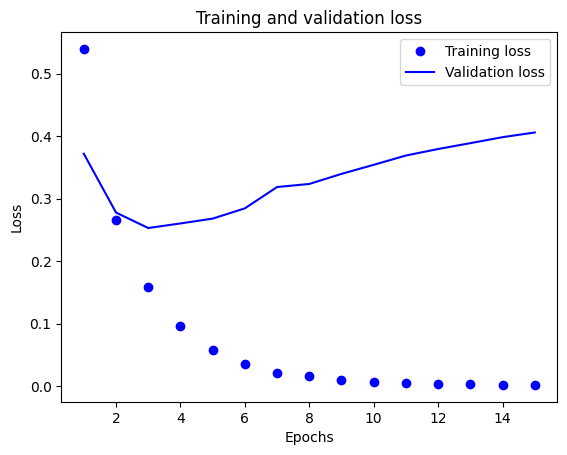

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

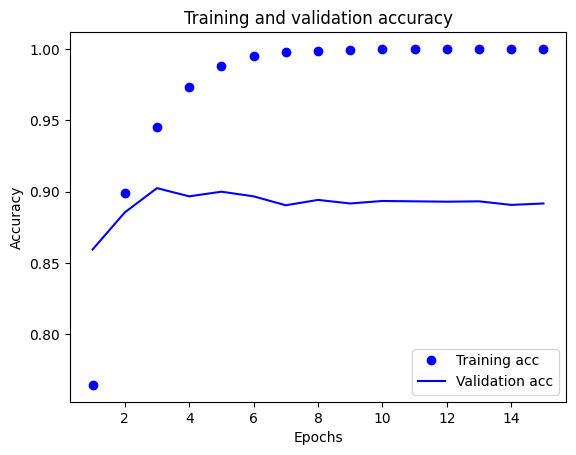

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Performance evaluation:
Evaluation method is model.evaluation(), it is based on accuracy. It returns the accuracy and loss. This is a very clear indication of how well our model does for the dataset that the model did not see. Loss is showed for each epoch.

In general, the model did pretty well because we can see for the validation dataset, the accuracy is around 89%, which is not bad, but it probably can improve.

Usually a random model would probably give a loss at around 70%, here my model has loss at around 35%, which means it's better than random guess.
However, training loss is significantly lower, therefore the model is most likely overfitting!
Overfitting means it takes too much features out of the training data.
This is an indication that 128 dimensions is probably too many. By decreasing the dimensions, it will allow our model to run faster, and also potentially be more accurate with less loss. It's not always the more complicated the better, need to find the sweet spot for the mode.

Also, as always, we are limited by input data. Different people will describe different genres of movies also differently. People might say 'very laughable' to a comedy as a compliment, but if same phrase is used for thriller movie, it might not be a positive review. In that sense maybe making a connection between genre and comment can be helpful? Which means maybe more layeres of feature extraction might help?